# Лабораторная работа №4

ФИО:   Щедрова Милана Вячеславовна
Группа: БИВТ-21-3

Отправлять можно следующими способами:
1. Запушить этот ноутбук в GitHub в репозиторий, где у вас лежат ноутбуки с лабами

Deadlines:
- Занятие №8 в семестре (Занятие №4 очное)

Что необходимо сделать:  
- Обучить различные модели глубокого обучения на имеющихся данных  

---
## Читайте задание внимательно

Исходные данные:
1. В [табличке](https://docs.google.com/spreadsheets/d/11600OkqdRzxc-xZmFTuBs099VeAqU_GlE0Bx6bBlIRE/edit?usp=sharing) необходимо узнать название своего датасета 
2. Скачать нужны вам данные можно в [Google Drive](https://drive.google.com/drive/folders/1Phm-Fq1GL-VX7NS-DCEMRh_Fo1wU7DQ9?usp=sharing)
  
---
Теперь по пунктам, что я от вас жду:  
1. Загрузить необходимые данные к себе и считать (read) их в переменную.
2. Понять, у вас задача классификации (бинарной или многоклассовой) или регрессии.
3. Сделать предобработку данных:  
     1. Разделить выборку на тренировочную (train) и тестовую (test). _Обратите внимание, что обучать скейлеры и определять, какими значениями вы будете заполнять пропуски, вы будете на train выборке, а применять и на train, и на test_.
     2. Проверить пропуски в данных. Если они есть, заполнить одной из стратегий, предложенных в ноутбуке для семинара №3. P.S. Для численных и категориальных переменных будут разные стратегии.
     3. Отнормировать численные переменные (`StandardScaler`, `MinMaxScaler`).
     4. Закодировать категориальные признаки по одной из стратегий.
4. Оформить данные в виде класса `Dataset` из библиотеки `torch` (как мы это делали на семинаре), а затем засунуть в `Dataloader` (тоже делали на семинаре).
5. Обучить на тренировочном множестве:
     1. Очень простую однослойную нейросеть с оптимизатором `SGD` ([link](https://pytorch.org/docs/stable/optim.html)).
     2. Нейросеть посложнее (с 1 скрытым слоем) с оптимизатором `Adam` ([link](https://pytorch.org/docs/stable/optim.html)).
     3. Нейросеть еще сложнее (с 3+ скрытыми слоями) с оптимизатором `Adam` ([link](https://pytorch.org/docs/stable/optim.html)).
6. Посчитайте loss на train и test множествах, в зависимости от эпохи обучения. Провизуализируйте это с помощью библиотеки `matplotlib` (выйдет так называемая **learning curve**, кривая обучения модели).
6. Посчитайте метрики на train и test множествах:
     1. Для задачи классификации -- Accuracy
     2. Для задачи регрессии -- MAE
7. Сравните метрики относительно train/test, так и относительно разных моделей. Ответьте на следующие вопросы:
     1. Какая модель справилась лучше с поставленной задачей?
     2. Имеет ли место переобучение?
     3. Имеет ли место недообучение?
     4. Как можно улучшить метрики моделей?

---
P.S.  
Просьба -- делать каждое задание в отдельных ячейках и с отдельными заголовками (как пункт 1 и 2 в этом ноутбуке) типа  
- Заголовок
- Ячейки с кодом
- Другой заголовок
- Другие ячейки с кодом

P.S.S.  
Если вам повезло с многоклассовой классификацией, у вас не будет проблем, просто нужно будет поставить необходимое количество нейронов на выходе вашей нейросети.

## Импорт библиотек

In [18]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import log_loss, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

## 1. Загрузка данных

In [19]:
data = pd.read_csv('student_data.csv')
data.head()  # если нужно, можно поменять разделитель

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


## 2. Тип задачи

Задача регрессии

## 3. Предобработка данных

1. Разделить выборку на тренировочную (train) и тестовую (test).

In [20]:
X = data.drop(columns=['G3'])  # Удаляем столбец с метками из данных
y = data['G3']  # Метки для обучения

# Разделяем данные на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
numeric_columns = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

2. Проверить пропуски в данных.
    

In [22]:
data.isna().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

 3. Отнормировать численные переменные (`StandardScaler`, `MinMaxScaler`).

In [23]:
# Инициализация скейлеров
scaler_standard = StandardScaler()
# scaler_minmax = MinMaxScaler()

X_train_scaled_standard = scaler_standard.fit_transform(X_train[numeric_columns])
X_test_scaled_standard = scaler_standard.fit_transform(X_test[numeric_columns])

# X_train_scaled_minmax = scaler_minmax.fit_transform(X_train[numeric_columns])
# X_test_scaled_minmax = scaler_minmax.fit_transform(X_test[numeric_columns])

# Заменяем оригинальные числовые столбцы на отмасштабированные
X_train[numeric_columns] = X_train_scaled_standard
X_test[numeric_columns] = X_test_scaled_standard

4. Закодировать категориальные признаки по одной из стратегий.

In [24]:
encoder = OneHotEncoder(sparse_output=False)

# Обучаем энкодер на тренировочных данных и преобразуем тренировочные и тестовые данные
X_train_encoded = encoder.fit_transform(X_train[categorical_columns])
X_test_encoded = encoder.fit_transform(X_test[categorical_columns])

# OneHotEncoder возвращает массив NumPy, поэтому преобразуем его обратно в DataFrame
encoded_columns = list(encoder.get_feature_names_out(categorical_columns))  # Получаем новые имена столбцов
X_train_encoded_df = pd.DataFrame(X_train_encoded, index=X_train.index, columns=encoded_columns)
X_test_encoded_df = pd.DataFrame(X_test_encoded, index=X_test.index, columns=encoded_columns)

# Удаляем оригинальные категориальные столбцы и добавляем закодированные
X_train_final = X_train.drop(columns=categorical_columns).join(X_train_encoded_df)
X_test_final = X_test.drop(columns=categorical_columns).join(X_test_encoded_df)

## 4. Оформление данных

In [25]:
# Определение класса Dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.tensor(self.features.iloc[idx], dtype=torch.float), torch.tensor(self.labels.iloc[idx])

# Создание экземпляров Dataset для тренировочных и тестовых данных
train_dataset = CustomDataset(X_train_final, y_train)
test_dataset = CustomDataset(X_test_final, y_test)

In [26]:
# Определите размер батча
batch_size = 32

# Создайте DataLoader для тренировочных и тестовых данных
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## 5. Обучение на тренирочном множестве и ## 6. Подсчет loss на train и test множествах



1. Очень простая однослойная нейросеть с оптимизатором `SGD`

Epoch 1/10


C:\Users\Милана\AppData\Local\Temp\ipykernel_23368\24356119.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(self.features.iloc[idx], dtype=torch.float), torch.tensor(self.labels.iloc[idx])


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 61.4313 - val_loss: 12.4860
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.9572 - val_loss: 8.0899
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.8777 - val_loss: 6.7113
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4787 - val_loss: 6.1066
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7642 - val_loss: 5.8128
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3651 - val_loss: 5.6611
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.1208 - val_loss: 5.5799
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.9580 - val_loss: 5.5360
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.8412 - val_loss: 5.5125
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.7518 - val_loss: 5.5007


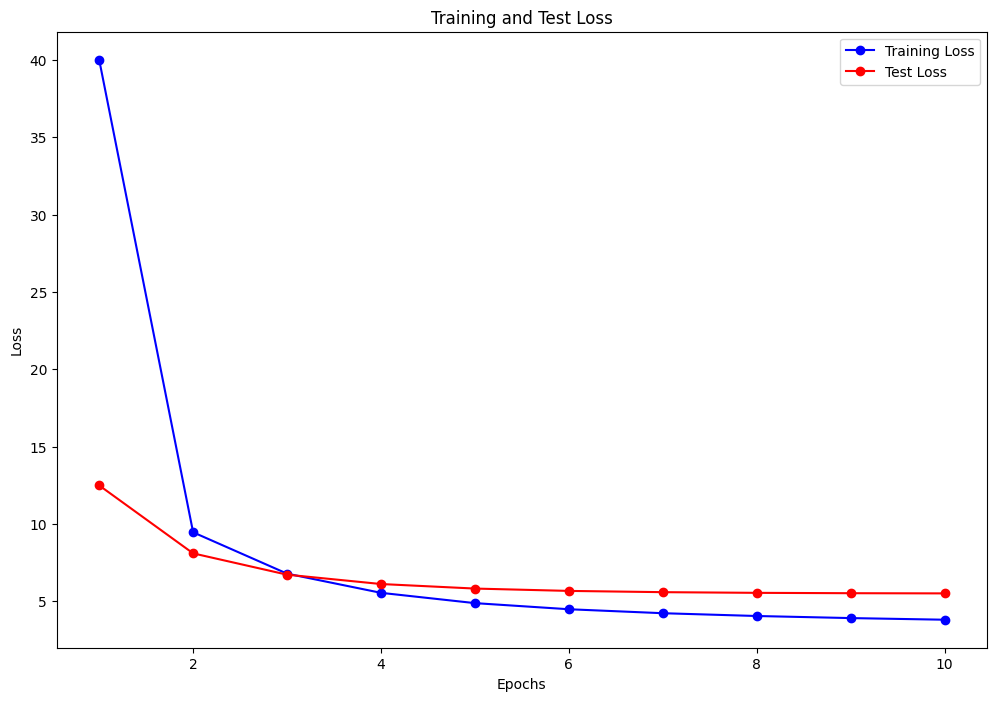

In [27]:
model_simple = Sequential([
    Input(shape=(X_train_final.shape[1],)),
    Dense(units=1, activation='linear')
])

model_simple.compile(optimizer=SGD(), loss='mean_squared_error')

history = model_simple.fit(train_loader, validation_data = (test_loader), epochs=10) 

train_loss = history.history['loss']

test_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 8))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, test_loss, 'ro-', label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

 2. Нейросеть посложнее (с 1 скрытым слоем) с оптимизатором `Adam` 


Epoch 1/10


C:\Users\Милана\AppData\Local\Temp\ipykernel_23368\24356119.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(self.features.iloc[idx], dtype=torch.float), torch.tensor(self.labels.iloc[idx])


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 132.4090 - val_loss: 127.9324
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 109.6018 - val_loss: 105.9092
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 90.0072 - val_loss: 85.6489
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 72.0698 - val_loss: 66.7645
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 55.4065 - val_loss: 49.5578
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 40.6558 - val_loss: 35.0960
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 28.6812 - val_loss: 24.2789
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 20.2229 - val_loss: 17.4350
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 15.3054 - val_loss: 13.8126
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 12.9119 - val_loss: 12.0801


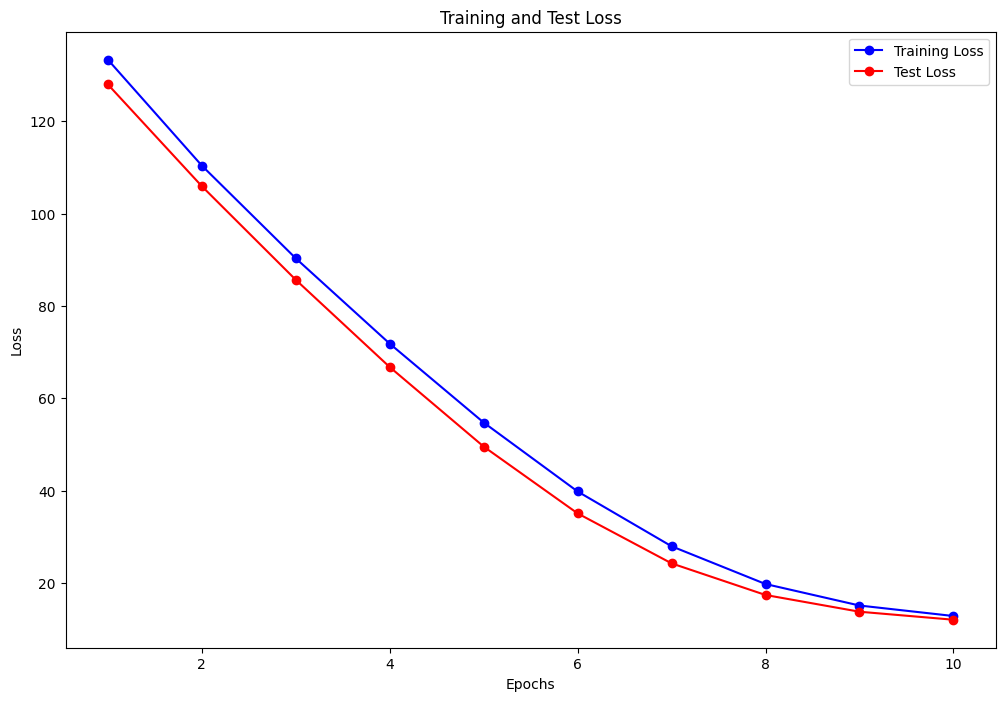

In [28]:
model_intermediate = Sequential([
    Input(shape=(X_train_final.shape[1],)),  
    Dense(units=64, activation='relu'),       
    Dense(units=1, activation='linear')
])

model_intermediate.compile(optimizer=Adam(), loss='mean_squared_error')

history = model_intermediate.fit(train_loader, validation_data = (test_loader), epochs=10) 

train_loss = history.history['loss']

test_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 8))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, test_loss, 'ro-', label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

3. Нейросеть еще сложнее (с 3+ скрытыми слоями) с оптимизатором `Adam` 

Epoch 1/10


C:\Users\Милана\AppData\Local\Temp\ipykernel_23368\24356119.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(self.features.iloc[idx], dtype=torch.float), torch.tensor(self.labels.iloc[idx])


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 118.3993 - val_loss: 101.5478
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 79.6814 - val_loss: 50.4725
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 32.9102 - val_loss: 13.3952
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 14.5667 - val_loss: 12.3234
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 11.7247 - val_loss: 9.4801
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.8700 - val_loss: 7.4332
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.8886 - val_loss: 6.2443
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.2298 - val_loss: 5.9456
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4756 - val_loss: 5.5868
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.0833 - val_loss: 5.4405


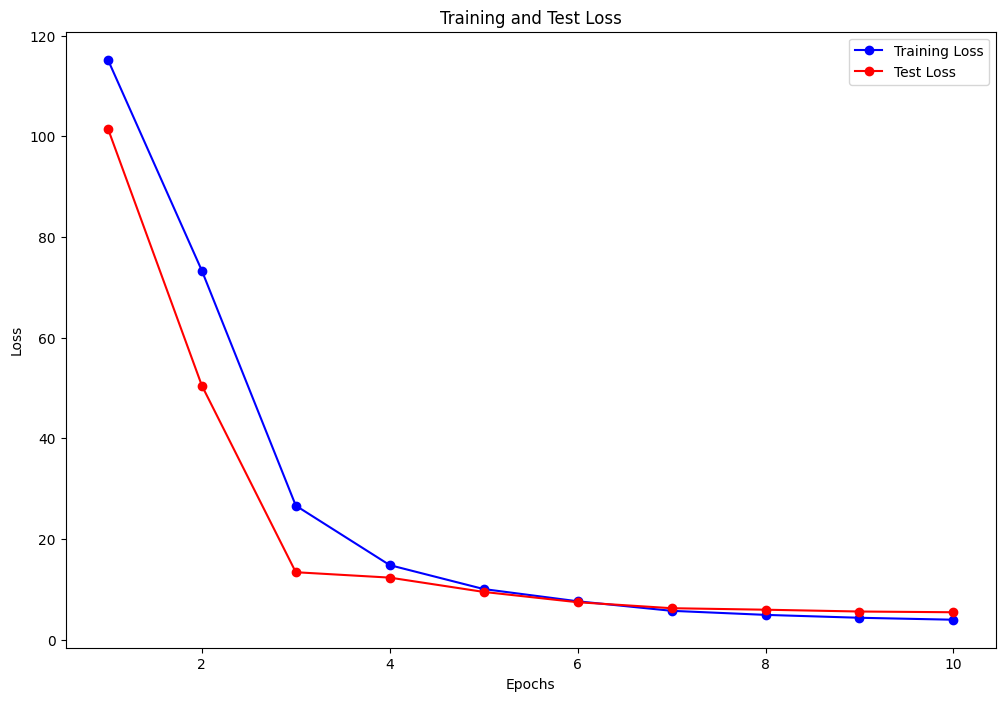

In [29]:
model_complex = Sequential([
    Input(shape=(X_train_final.shape[1],)),
    Dense(units=128, activation='relu'),     
    Dense(units=64, activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1, activation='linear')
])

model_complex.compile(optimizer=Adam(), loss='mean_squared_error')

history = model_complex.fit(train_loader, validation_data = (test_loader), epochs=10) 

train_loss = history.history['loss']

test_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 8))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, test_loss, 'ro-', label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 7. Подсчет метрик на train и test множествах

In [30]:
# Список для хранения моделей
models = [model_simple, model_intermediate, model_complex]

for i, model in enumerate(models):
    # Получаем предсказания модели на тренировочном и тестовом наборах
    train_preds = model.predict(X_train_final).flatten()
    test_preds = model.predict(X_test_final).flatten()
    
    # Вычисляем MAE для тренировочного набора
    train_mae = mean_absolute_error(y_train, train_preds)
    # Вычисляем MAE для тестового набора
    test_mae = mean_absolute_error(y_test, test_preds)
    
    # Выводим результаты
    print(f'Model {i+1} - Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Model 1 - Train MAE: 1.3472, Test MAE: 1.6032
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Model 2 - Train MAE: 2.5065, Test MAE: 2.7477
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
Model 3 - Train MAE: 1.3899, Test MAE: 1.7097


## 8. Сравнение метрик относительно train/test

Исходя из метрики средней абсолютной ошибки (MAE), Model 1 показывает лучшие результаты на тестовом наборе данных (Test MAE: 1.6351) по сравнению с Model 2 и Model 3. Это может быть признаком того, что добавление дополнительных слоев не привело к значительному улучшению производительности для данной задачи или данных.
1. Какая модель справилась лучше с поставленной задачей?
Однослойная нейросеть с оптимизатором SGD
2. Имеет ли место переобучение?
Нет
3. Имеет ли место недообучение?
Нет
4. Как можно улучшить метрики моделей?
 Изменение архитектуры моделей
 Оптимизация гиперпараметров моделей
 Более тщательная предобработка данных